In [1]:
import numpy as np
import xarray as xr
import os.path as op
import dask.array as dsar
from dask.diagnostics import ProgressBar
import xrft
from scipy.fftpack import dst, fftfreq
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/swot/SUM05/takaya/MITgcm/channel/runs/'

In [3]:
ys, dy = (240,20)
ts = int(360*86400*ys/6e2+144)
te = int(360*86400*(ys+dy)/6e2+144)
print(ts,te)

12441744 13478544


In [4]:
ds1 = open_mdsdataset(op.join(ddir,'deepML-2mon_potP'), iters=range(ts,te,144),
                     prefix=['HydroPresPot'],
                     delta_t=6e2
                     )
ds1

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/deepML-2mon_potP. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:              (XC: 100, XG: 100, YC: 200, YG: 200, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 7200)
Coordinates:
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * XG                   (XG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * YG                   (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    rA                   (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    dxG                  (YG, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>


In [5]:
f0 = -1.1e-4
beta = 1.4e-11
g = 9.81
grid = Grid(ds1, periodic=['X'])
# with ProgressBar():
#     phi = ds1.PHIHYD.load()
phi = ds1.PHIHYD
# phi.chunk(chunks={'time':1,'Z':1,'YC':200,'XC':100})

In [29]:
func = xrft.detrend_wrap(xrft.detrendn)
phip = xr.DataArray(func(phi.chunk(chunks={'time':1,'Z':1,'YC':200,'XC':100}).data, axes=[2,3]),
                   dims=phi.dims, coords=phi.coords)
phip

<xarray.DataArray 'detrendn-d47ae40fa6392a786ee6fd98082c90ac' (time: 7200, Z: 40, YC: 200, XC: 100)>
dask.array<shape=(7200, 40, 200, 100), dtype=float32, chunksize=(1, 1, 200, 100)>
Coordinates:
  * XC       (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
  * YC       (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 65000.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
    rA       (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    Depth    (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    drF      (Z) >f4 dask.array<shape=(40,), chunksize=(40,)>
    PHrefC   (Z) >f4 dask.array<shape=(40,), chunksize=(40,)>
    hFacC    (Z, YC, XC) >f4 dask.array<shape=(40, 200, 100), chunksize=(40, 200, 100)>
    iter     (time) int64 dask.array<shape=(7200,), chunksize=(1,)>
  * time     (time) float64 7.465e+09 7.465e+09 7.465e+09 7.465e+09 ...

In [30]:
f = f0 + beta*ds1.YC
b = grid.interp(grid.diff(phip,'Z',boundary='fill')/grid.diff(phi.Z,'Z',boundary='fill'),
                'Z',boundary='fill')
ug = -grid.diff(phip,'Y',boundary='fill')/grid.diff(phi.YC,'Y',boundary='fill')
vg = grid.diff(phip,'X')/grid.diff(phi.XC,'X')
print(b.dims, ug.dims, vg.dims)

('time', 'Z', 'YC', 'XC') ('time', 'Z', 'YG', 'XC') ('time', 'Z', 'YC', 'XG')


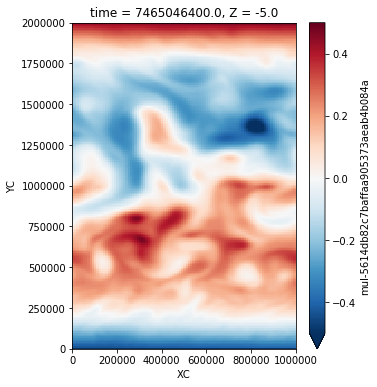

In [42]:
b[0,0].plot(figsize=(5,6), vmax=.5, vmin=-.5, cmap='RdBu_r')

In [31]:
zetag = (grid.diff(vg,'X')/grid.diff(vg.XG,'X') 
        - grid.diff(ug,'Y',boundary='fill')/grid.diff(ug.YG,'Y',boundary='fill')
        ) * f**-1

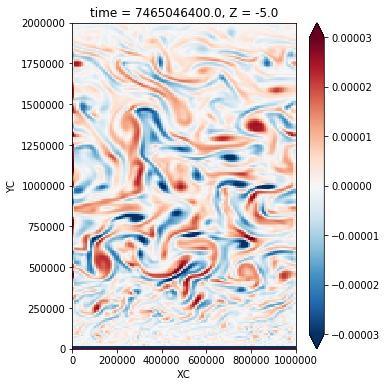

In [32]:
zetag[0,0].plot(figsize=(5,6), vmax=3e-5)

In [33]:
(grid.interp(ug,'Y',boundary='fill') * f**-1)[::15,::2].to_dataset(name='u_geo').to_netcdf(op.join(ddir,'zonal_geovel.nc'))
(grid.interp(vg,'X') * f**-1)[::15,::2].to_dataset(name='v_geo').to_netcdf(op.join(ddir,'meri_geovel.nc'))
zetag[::15,::2].to_dataset(name='vort_geo').to_netcdf(op.join(ddir,'vorticity_geo.nc'))
b[::15,::2].to_dataset(name='b').to_netcdf(op.join(ddir,'buoyancy.nc'))

In [9]:
ds2 = open_mdsdataset(op.join(ddir,'deepML-2mon_mom'), iters=range(ts,te,144),
                     prefix=['Mom_tave'],
                     delta_t=6e2
                     )
ds2

/home/takaya/xmitgcm/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/takaya/MITgcm/channel/runs/deepML-2mon_mom. Using default version.
  "in %s. Using default version." % data_dir)
/home/takaya/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/takaya/xmitgcm/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:              (XC: 100, XG: 100, YC: 200, YG: 200, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 7200)
Coordinates:
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 ...
  * XG                   (XG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * YG                   (YG) >f4 0.0 10000.0 20000.0 30000.0 40000.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    rA                   (YC, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>
    dxG                  (YG, XC) >f4 dask.array<shape=(200, 100), chunksize=(200, 100)>


In [43]:
ua = (grid.interp(grid.interp(ds2.UVEL,'Y',boundary='fill'),'X') 
      + grid.diff(phi,'Y',boundary='fill')/grid.diff(phi.YC,'Y',boundary='fill') * (f0+beta*ds1.YG)**-1
     )
va = (grid.interp(grid.interp(ds2.VVEL,'Y',boundary='fill'),'X') 
      - grid.diff(phip,'X')/grid.diff(phi.XC,'X') * (f0+beta*ds1.YC)**-1
     )
zetaa = (grid.diff(va,'X')/grid.diff(va.XG,'X') 
         - grid.diff(ua,'Y',boundary='fill')/grid.diff(ua.YG,'Y',boundary='fill')
        )
# ug = grid.interp(ug,'Y',boundary='fill') * f**-1
# vg = grid.interp(vg,'X') * f**-1

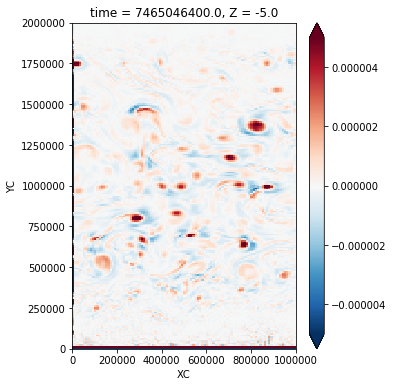

In [44]:
zetaa[0,0].plot(figsize=(5,6), vmax=5e-6)

In [45]:
ua[::15,::2].to_dataset(name='u_ageo').to_netcdf(op.join(ddir,'zonal_ageovel.nc'))
va[::15,::2].to_dataset(name='v_ageo').to_netcdf(op.join(ddir,'meri_ageovel.nc'))
zetaa[::15,::2].to_dataset(name='vort_ageo').to_netcdf(op.join(ddir,'vorticity_ageo.nc'))

In [ ]:
phik = xrft.dft(phi[::15,::2].chunk(chunks={'time':1,'Z':1,'YC':1}), dim=['XC'], shift=False)
phik

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


<xarray.DataArray 'fftn-adc5896714b2b084e6ab3c4260efd97f' (time: 480, Z: 20, YC: 200, freq_XC: 100)>
dask.array<shape=(480, 20, 200, 100), dtype=complex128, chunksize=(1, 1, 1, 100)>
Coordinates:
  * time             (time) float64 7.465e+09 7.466e+09 7.468e+09 7.469e+09 ...
  * Z                (Z) >f4 -5.0 -25.0 -49.0 -81.5 -126.0 -187.0 -272.0 ...
  * YC               (YC) >f4 5000.0 15000.0 25000.0 35000.0 45000.0 55000.0 ...
  * freq_XC          (freq_XC) float64 0.0 1e-06 2e-06 3e-06 4e-06 5e-06 ...
    freq_XC_spacing  float64 1e-06

In [ ]:
phikl = xrft.dft(phik.chunk(chunks={'time':1,'Z':1,'freq_XC':1,'YC':200}), dim=['YC'], 
                 shift=False, window=True, detrend='linear')
with ProgressBar():
    phikl.load()
phikl

/home/takaya/xrft/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


[#######                                 ] | 18% Completed | 19min 10.7s

In [10]:
kx = phikl.freq_XC * 2*np.pi
ky = phikl.freq_YC * 2*np.pi

print(kx,ky)

<xarray.DataArray 'freq_XC' (freq_XC: 100)>
array([ 0.000000e+00,  6.283185e-06,  1.256637e-05,  1.884956e-05,
        2.513274e-05,  3.141593e-05,  3.769911e-05,  4.398230e-05,
        5.026548e-05,  5.654867e-05,  6.283185e-05,  6.911504e-05,
        7.539822e-05,  8.168141e-05,  8.796459e-05,  9.424778e-05,
        1.005310e-04,  1.068142e-04,  1.130973e-04,  1.193805e-04,
        1.256637e-04,  1.319469e-04,  1.382301e-04,  1.445133e-04,
        1.507964e-04,  1.570796e-04,  1.633628e-04,  1.696460e-04,
        1.759292e-04,  1.822124e-04,  1.884956e-04,  1.947787e-04,
        2.010619e-04,  2.073451e-04,  2.136283e-04,  2.199115e-04,
        2.261947e-04,  2.324779e-04,  2.387610e-04,  2.450442e-04,
        2.513274e-04,  2.576106e-04,  2.638938e-04,  2.701770e-04,
        2.764602e-04,  2.827433e-04,  2.890265e-04,  2.953097e-04,
        3.015929e-04,  3.078761e-04, -3.141593e-04, -3.078761e-04,
       -3.015929e-04, -2.953097e-04, -2.890265e-04, -2.827433e-04,
       -2.764602e-

In [12]:
with ProgressBar():
    ug = dsar.fft.ifft2((-1j * phikl * ky).chunk(chunks={'time':1,'Z':1,'freq_XC':100,'freq_YC':200}).data, 
                       axes=[-2,-1]).compute()
    vg = dsar.fft.ifft2((1j * phikl * kx).chunk(chunks={'time':1,'Z':1,'freq_XC':100,'freq_YC':200}).data, 
                       axes=[-2,-1]).compute()
#     phip = dsar.fft.ifft2(phikl.chunk(chunks={'time':1,'Z':1,'freq_XC':100,'freq_YC':200}).data, 
#                          axes=[-2,-1]).compute()
    zetag = dsar.fft.ifft2((-phikl*(kx**2+ky**2)).chunk(chunks={'time':1,'Z':1,'freq_XC':100,'freq_YC':200}).data, 
                          axes=[-2,-1]).compute()

[########################################] | 100% Completed | 20.2s
[########################################] | 100% Completed | 17.6s
[########################################] | 100% Completed | 15.8s


In [18]:
ug = xr.DataArray(ug.real, dims=phi[::15,::2].dims, coords=phi[::15,::2].coords) * (f0+beta*ds1.YC)**-1
vg = xr.DataArray(vg.real, dims=phi[::15,::2].dims, coords=phi[::15,::2].coords) * (f0+beta*ds1.YC)**-1
# phip = xr.DataArray(phip.real, dims=phi.dims, coords=phi.coords)
zetag = xr.DataArray(zetag.real, dims=phi[::15,::2].dims, coords=phi[::15,::2].coords) * (f0+beta*ds1.YC)**-1
# b = grid.interp(grid.diff(phip,'Z',boundary='fill')
#                 / grid.diff(phip.Z,'Z',boundary='fill'), 
#                'Z', boundary='fill')

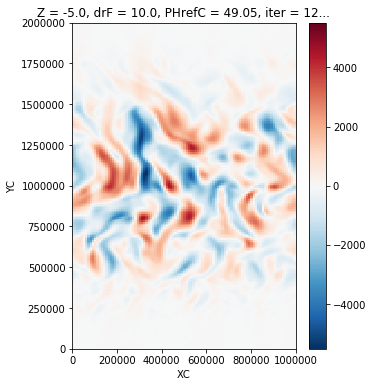

In [28]:
vg[0,0].plot(figsize=(5,6))

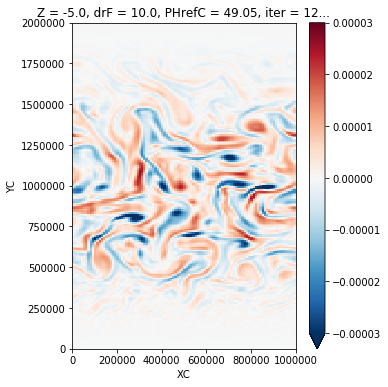

In [27]:
zetag[0,0].plot(figsize=(5,6),vmax=3e-5)